In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np 
import milopy
import scipy
import warnings

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


## Preparation

In [6]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'

In [8]:
def _get_model_vars(model_dir):
    vars = sc.read(model_dir + '/adata.h5ad', backed=True).var
    return(vars)

In [33]:
## Make directories to save results
import shutil
cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
for ct in cts_oi:
    print(ct)
    simdir = outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
    if not os.path.exists(simdir + 'HVG_comparison'):
        os.mkdir(simdir + 'HVG_comparison')
    # Copy trained models to new directory
    model_dirs = [f'{simdir}/{x}' for x in os.listdir(simdir) if x.startswith('model_')]
    for m in model_dirs:
        new_m = m.replace('/model_', '/HVG_comparison/model_5000HVG_')
        print(new_m)
        shutil.copytree(m, new_m, dirs_exist_ok=True)

naive_B_cell
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_ctrlquery
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_fit_query2atlas
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_fit_query2ctrl
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typenaive_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022//HVG_comparison/model_5000HVG_atlas
/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cel

In [28]:
('ACR', 'scArches', 5000, False) # done
('ACR', 'scArches', 2500, False)
('ACR', 'scArches', 10000, False)

('CR', 'scArches', 5000, False) # done
('CR', 'scVI', 5000, False) # done
('CR', 'scArches', 5000, True) 
('CR', 'scVI', 5000, True)
('CR', 'scArches', 2500, False) 
('CR', 'scVI', 2500, False) 
('CR', 'scArches', 2500, True) 
('CR', 'scVI', 2500, True)
('CR', 'scArches', 10000, False) 
('CR', 'scVI', 10000, False) 
('CR', 'scArches', 10000, True) 
('CR', 'scVI', 10000, True)

'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/model_5000HVG_atlasctrlquery'

```
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/_misc/hvg_selection/

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/
cts="natural_killer_cell classical_monocyte naive_B_cell central_memory_CD4_positive_alpha_beta_T_cell"
dirs=$(for c in $cts; do dirname $outdir/*500cells*${c}*/ACR_design.scArches_milo.h5ad; done)

for d in $dirs; do
    design=CR
      echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scVI --fixed_hvgs --hvg_data atlas" | \
                     bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
     echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data atlas" | \
                     bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scVI --fixed_hvgs --hvg_data ctrl" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data ctrlquery" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

    done
```


## Parse results

In [13]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc
from oor_benchmark.methods.scArches_milo import run_milo

def harmonize_output(adata, signif_alpha=0.1):
#     if adata.isbacked:
#         sample_adata = adata.uns['nhood_adata'].to_memory().T
#     else:
    sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()

def read_oor_design_output(simdir, ref_design, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_seed')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.h5ad'
    adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=False)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

def parse_design(adata, ref_design, hvg_data, emb_method):
    if 'sample_adata' not in adata.uns:
        harmonize_output(adata)
    perturb_pop = adata.obs['OOR_state_name'].unique()[0]
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = perturb_pop
    tpr_df['emb_method'] = emb_method
    tpr_df['hvg_data'] = hvg_data
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = perturb_pop
    auprc_df['emb_method'] = emb_method
    auprc_df['hvg_data'] = hvg_data
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = perturb_pop
    nhoods_df['emb_method'] = emb_method
    nhoods_df['hvg_data'] = hvg_data
    return(nhoods_df, tpr_df, auprc_df)

Global seed set to 0


In [14]:
n_hvgs = 5000
emb_method = 'scVI'
hvg_data = 'atlas'
population_obs = 'cell_type'

def read_result(simdir,
    n_hvgs = 5000,
    population_obs = 'cell_type'
    ):
    nhoods_df_all = pd.DataFrame()
    tpr_df_all = pd.DataFrame()
    auprc_df_all = pd.DataFrame()
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    print(f'Reading {perturb_pop}\n')
    for n_hvgs in [2500, 5000, 10000]:
        for emb_method in ['scVI', 'scArches']:
            for d in ['ACR', "CR"]:
                if d == 'CR':
                    for hvg_data in ['atlas', 'new','ctrl', 'ctrlquery']:
                        if hvg_data == 'atlas':
                            h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
                        else:
                            if n_hvgs == 5000:
                                h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
                            else:
                                h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'    
                        try:
                            adata = milopy.utils.read_milo_adata(h5ad_file, backed=False)
                        except:
                            continue
                        adata.obs['OOR_state_name'] = perturb_pop
                        print(d, hvg_data, emb_method, n_hvgs)
                        nhoods_df, tpr_df, auprc_df = parse_design(adata, d, emb_method=emb_method, hvg_data=hvg_data)
                        nhoods_df['n_hvgs'] = n_hvgs
                        tpr_df['n_hvgs'] = n_hvgs
                        auprc_df['n_hvgs'] = n_hvgs
                        nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
                        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
                        auprc_df_all = pd.concat([auprc_df_all, auprc_df])
                else:
                    hvg_data = 'new'
                    if n_hvgs == 5000:
                        h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
                    else:
                        h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
                    try:
                        adata = milopy.utils.read_milo_adata(h5ad_file, backed=False)
                    except:
                        continue
                    adata.obs['OOR_state_name'] = perturb_pop
                    print(d, hvg_data, emb_method, n_hvgs)
                    nhoods_df, tpr_df, auprc_df = parse_design(adata, d, emb_method=emb_method, hvg_data=hvg_data)
                    nhoods_df['n_hvgs'] = n_hvgs
                    tpr_df['n_hvgs'] = n_hvgs
                    auprc_df['n_hvgs'] = n_hvgs
                    nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
                    tpr_df_all = pd.concat([tpr_df_all, tpr_df])
                    auprc_df_all = pd.concat([auprc_df_all, auprc_df])

    # print(auprc_df_all.head())
    nhoods_df_all.to_csv(simdir + f'/HVG_comparison/nhoods_obs.csv')
    tpr_df_all.to_csv(simdir + f'/HVG_comparison/TPR_res.csv')
    auprc_df_all.to_csv(simdir + f'/HVG_comparison/AUPRC_res.csv')

## Is HVG selection determining difference btw integration strategies in CR design?

In [11]:
cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
simdirs = [outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]

In [16]:
nhoods_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()

population_obs = 'cell_type'
n_hvgs = 5000
params = (("CR", 'scVI', 'ctrl'),
    ("CR", 'scVI', 'new'),
    ("CR", 'scVI', 'atlas'),
    ("CR", 'scArches', 'new'),
    ("CR", 'scArches', 'ctrlquery'),
    ("CR", 'scArches', 'atlas'),
    ("ACR", 'scArches', 'atlas'),
    ("ACR", 'scArches', 'new'),
    ("ACR", 'scArches', 'ctrl'),
    ("ACR", 'scArches', 'ctrlquery'))

for simdir in simdirs:
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    for p in params:
        d, emb_method, hvg_data = p
        if hvg_data == 'new':
            h5ad_file = simdir + f'/{d}_design.{emb_method}_milo.h5ad'
        else:
            h5ad_file = simdir + f'/HVG_comparison/{d}_design.{n_hvgs}HVG_{hvg_data}.{emb_method}_milo.h5ad'
        try:
            adata1 = milopy.utils.read_milo_adata(h5ad_file, backed=True)
        except:
            continue
        adata1.obs['OOR_state_name'] = perturb_pop
        adata1.uns['nhood_adata'] = adata1.uns['nhood_adata'].to_memory()
        nhoods_df, tpr_df, auprc_df = parse_design(adata1, d, emb_method=emb_method, hvg_data=hvg_data)
        nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
        auprc_df_all = pd.concat([auprc_df_all, auprc_df])

In [17]:
%%R -i auprc_df_all
head(auprc_df_all)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  Recall  Precision   AUPRC no_skill_thresh design OOR_state_name emb_method
1      1 0.06314700 0.42068        0.063147     CR   naive_B_cell       scVI
2      1 0.06321244 0.42068        0.063147     CR   naive_B_cell       scVI
3      1 0.06327801 0.42068        0.063147     CR   naive_B_cell       scVI
4      1 0.06334372 0.42068        0.063147     CR   naive_B_cell       scVI
5      1 0.06340956 0.42068        0.063147     CR   naive_B_cell       scVI
6      1 0.06347555 0.42068        0.063147     CR   naive_B_cell       scVI
  hvg_data
1     ctrl
2     ctrl
3     ctrl
4     ctrl
5     ctrl
6     ctrl


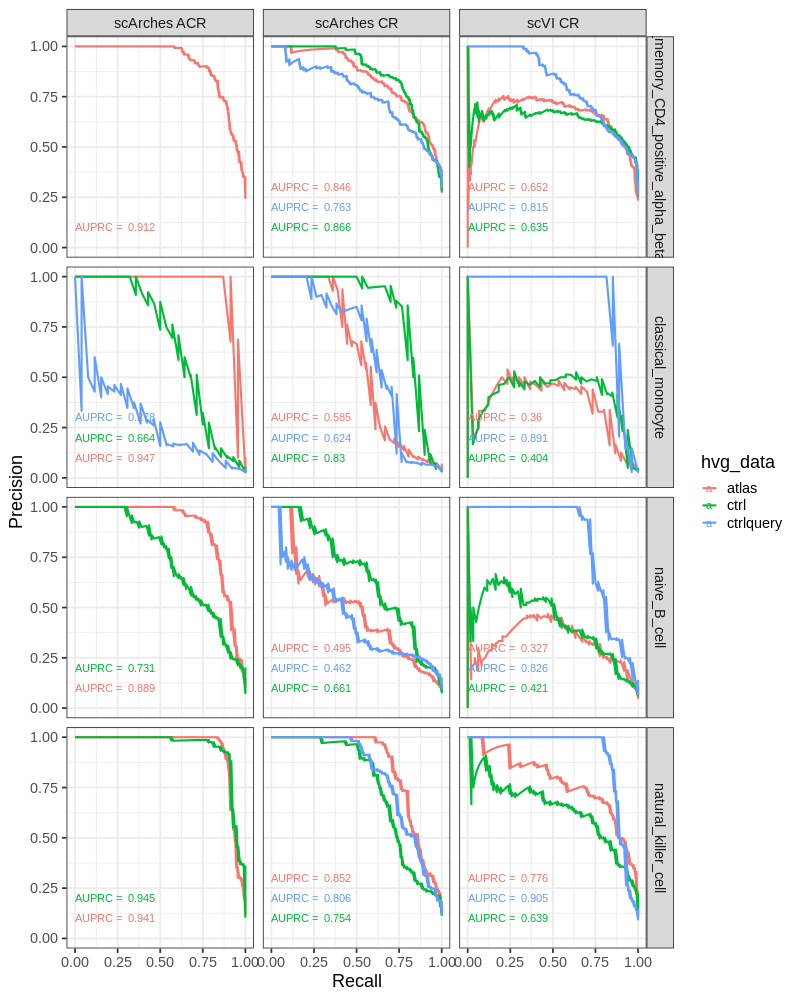

In [25]:
%%R -w 800 -h 1000
auprc_df_all %>%
mutate(g = paste(emb_method, design)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'CR', 'ctrl', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scArches' & hvg_data == 'new' & design == 'ACR', 'atlas', hvg_data)) %>%
mutate(hvg_data = ifelse(emb_method == 'scVI' & hvg_data == 'new', 'ctrlquery', hvg_data)) %>%
ggplot(aes(Recall, Precision, color=hvg_data))+
geom_line(size=1) +
geom_text(data=. %>% distinct(AUPRC, hvg_data, OOR_state_name, g, hvg_data) %>% group_by(OOR_state_name, g) %>% mutate(id = row_number()), 
          aes(label=paste('AUPRC = ',round(AUPRC, 3)), y=id*0.1), x=0, hjust=0) +
facet_grid(OOR_state_name~g) +
theme_bw(base_size=18)

In [198]:
def _get_model_vars(model_dir):
    vars = sc.read(model_dir + '/adata.h5ad', backed=True).var
    return(vars)

d = "CR"
n_hvgs = 5000
n_intersect_dict = {}
for simdir in simdirs:
    perturb_pop = simdir.split(population_obs)[1].split('_queryBatch')[0]
    vars_ctrl = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrl').index
    vars_ctrlquery = _get_model_vars(simdir + f'/HVG_comparison/model_5000HVG_ctrlquery').index
    n_intersect_dict[perturb_pop] = np.intersect1d(vars_ctrlquery, vars_ctrl).shape[0]
        

In [202]:
[x/5000 for x in n_intersect_dict.values()]

[0.8154, 0.7784, 0.8086, 0.8082]

```
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/_misc/hvg_selection/

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/
cts="natural_killer_cell classical_monocyte naive_B_cell central_memory_CD4_positive_alpha_beta_T_cell"
dirs=$(for c in $cts; do dirname $outdir/*500cells*${c}*/ACR_design.scArches_milo.h5ad; done)

for d in $dirs; do
    design=ACR
     echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data ctrl" | \
                     bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --fixed_hvgs --hvg_data ctrlquery" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"

    done
```

### Compare HVG numvers

In [99]:
cts_oi = ['naive_B_cell', 'central_memory_CD4_positive_alpha_beta_T_cell','natural_killer_cell', 'classical_monocyte']
simdirs = [outdir + f'qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022' for ct in cts_oi]
for d in simdirs:
    read_result(d)


Reading naive_B_cell

CR new scVI 2500
ACR new scArches 2500
CR new scArches 2500
ACR new scVI 5000
CR atlas scVI 5000
CR new scVI 5000
CR ctrl scVI 5000
CR ctrlquery scVI 5000
ACR new scArches 5000
CR atlas scArches 5000
CR new scArches 5000
CR ctrl scArches 5000
CR ctrlquery scArches 5000
CR new scVI 10000
ACR new scArches 10000
CR new scArches 10000
Reading central_memory_CD4_positive_alpha_beta_T_cell

CR new scVI 2500
ACR new scArches 2500
CR new scArches 2500
ACR new scVI 5000
CR atlas scVI 5000
CR new scVI 5000
CR ctrl scVI 5000
CR ctrlquery scVI 5000
ACR new scArches 5000
CR atlas scArches 5000
CR new scArches 5000
CR ctrl scArches 5000
CR ctrlquery scArches 5000
CR new scVI 10000
ACR new scArches 10000
Reading natural_killer_cell

CR new scVI 2500
ACR new scArches 2500
CR new scArches 2500
ACR new scVI 5000
CR atlas scVI 5000
CR new scVI 5000
CR ctrl scVI 5000
CR ctrlquery scVI 5000
ACR new scArches 5000
CR atlas scArches 5000
CR new scArches 5000
CR ctrl scArches 5000
CR ctrl

In [213]:
nhoods_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
for simdir in simdirs:
    nh_df = pd.read_csv(f'{simdir}/HVG_comparison/nhoods_obs.csv', index_col=0)
    tpr_df = pd.read_csv(f'{simdir}/HVG_comparison/TPR_res.csv', index_col=0)
    auprc_df = pd.read_csv(f'{simdir}/HVG_comparison/AUPRC_res.csv', index_col=0)
    auprc_df_all = pd.concat([auprc_df_all, auprc_df])
    nhoods_df_all = pd.concat([nhoods_df_all, nh_df])
    tpr_df_all = pd.concat([tpr_df_all, tpr_df])

In [214]:
auprc_df_all

,Recall,Precision,AUPRC,no_skill_thresh,design,OOR_state_name,emb_method,hvg_data,n_hvgs
0,1.000000,0.057411,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
1,1.000000,0.057471,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
2,1.000000,0.057531,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
3,1.000000,0.057592,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
4,1.000000,0.057652,0.892717,0.057411,CR,naive_B_cell,scVI,new,2500
...,...,...,...,...,...,...,...,...,...
958,0.173913,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000
959,0.130435,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000
960,0.086957,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000
961,0.043478,1.000000,0.844471,0.023909,CR,classical_monocyte,scArches,new,10000


In [228]:
auprc_pl = auprc_df_all[auprc_df_all['hvg_data'] == 'new']
auprc_pl = auprc_pl[['AUPRC','design', 'OOR_state_name', 'design', 'OOR_state_name', 'emb_method', 'hvg_data', 'n_hvgs']].drop_duplicates()

In [217]:
# auprc_pl = auprc_df_all[['AUPRC','design', 'OOR_state_name', 'design', 'OOR_state_name', 'emb_method', 'hvg_data', 'n_hvgs']].drop_duplicates()
# auprc_pl

In [229]:
%%R -i auprc_pl -i tpr_df_all
head(auprc_pl)

      AUPRC design OOR_state_name emb_method hvg_data n_hvgs
1 0.8927167     CR   naive_B_cell       scVI      new   2500
2 0.8095157    ACR   naive_B_cell   scArches      new   2500
3 0.6459480     CR   naive_B_cell   scArches      new   2500
4 0.9118807    ACR   naive_B_cell       scVI      new   5000
5 0.8256038     CR   naive_B_cell       scVI      new   5000
6 0.8894348    ACR   naive_B_cell   scArches      new   5000


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


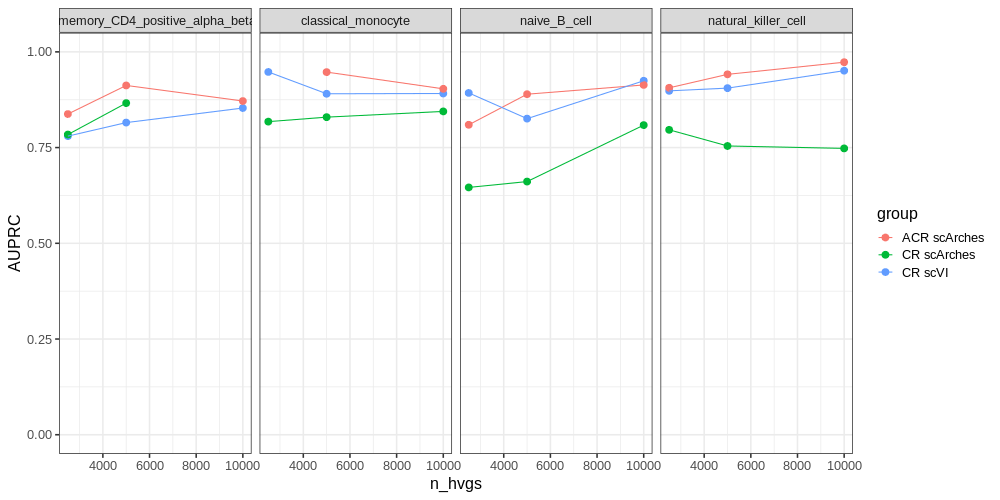

In [248]:
%%R -w 1000 -h 500
auprc_pl %>%
mutate(group = paste(design, emb_method)) %>%
filter(group != 'ACR scVI') %>%
ggplot(aes(n_hvgs, AUPRC, color=group)) +
geom_point(size=3) +
geom_line(aes(group=group)) +
ylim(0,1) +
theme_bw(base_size=16) +
facet_grid(.~OOR_state_name) 

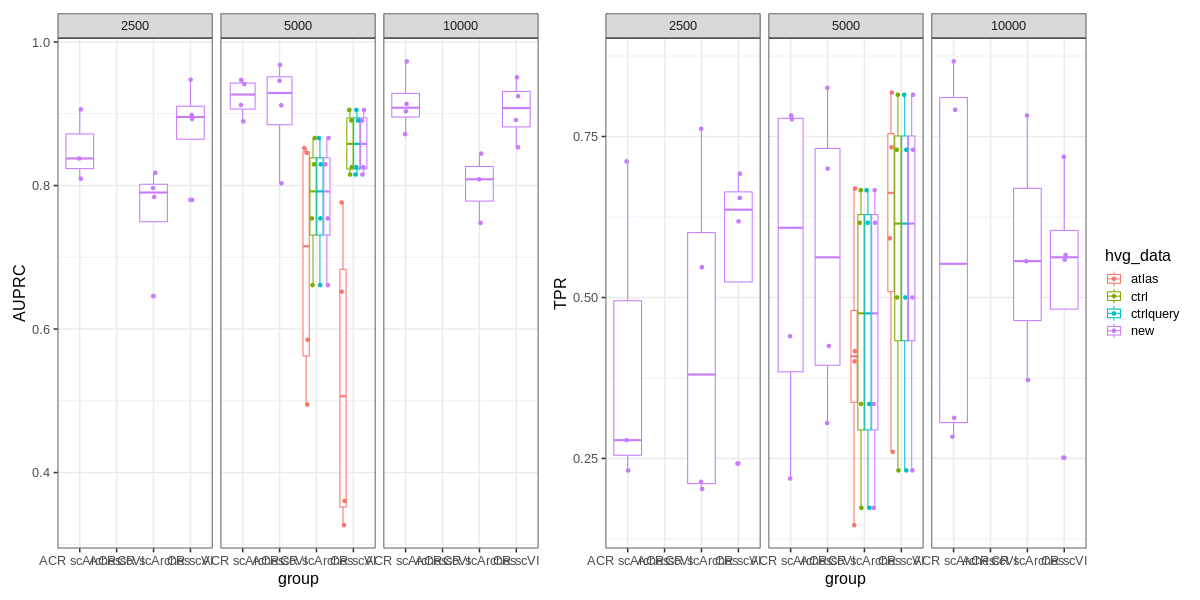

In [104]:
%%R -w 1200 -h 600
library(patchwork)

auprc_pl %>%
mutate(group = paste(design, emb_method)) %>%
ggplot(aes(group, AUPRC, color=hvg_data)) +
geom_boxplot() +
geom_point(position= position_jitterdodge(jitter.width=0.1))  +
theme_bw(base_size=16) +
facet_wrap(n_hvgs~.) +

tpr_df_all %>%
mutate(group = paste(design, emb_method)) %>%
ggplot(aes(group, TPR, color=hvg_data)) +
geom_boxplot() +
geom_point(position= position_jitterdodge(jitter.width=0.1))  +
theme_bw(base_size=16) +
facet_wrap(n_hvgs~.) +

plot_layout(guides='collect')

# tpr_df_all %>%
# mutate(group = paste(design, emb_method)) %>%
# ggplot(aes(group, FDR, color=hvg_data)) +
# geom_jitter(width=0.1) 

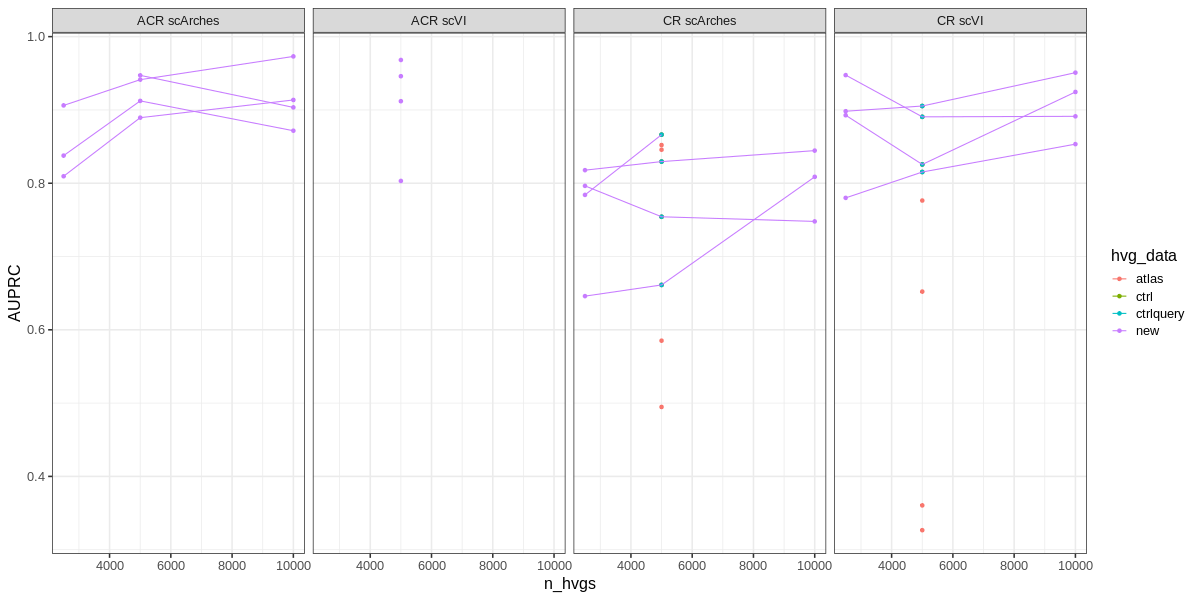

In [116]:
%%R -w 1200 -h 600
library(patchwork)

auprc_pl %>%
mutate(group = paste(design, emb_method)) %>%
mutate(group_line = paste(design, emb_method, hvg_data, OOR_state_name)) %>%
ggplot(aes(n_hvgs, AUPRC, color=hvg_data)) +
geom_point(position='dodge') +
geom_line(aes(group=group_line)) +
theme_bw(base_size=16) +
facet_grid(.~group) 

# tpr_df_all %>%
# mutate(group = paste(design, emb_method)) %>%
# ggplot(aes(group, TPR, color=hvg_data)) +
# geom_boxplot() +
# geom_point(position= position_jitterdodge(jitter.width=0.1))  +
# theme_bw(base_size=16) +
# facet_wrap(n_hvgs~.) +

# plot_layout(guides='collect')

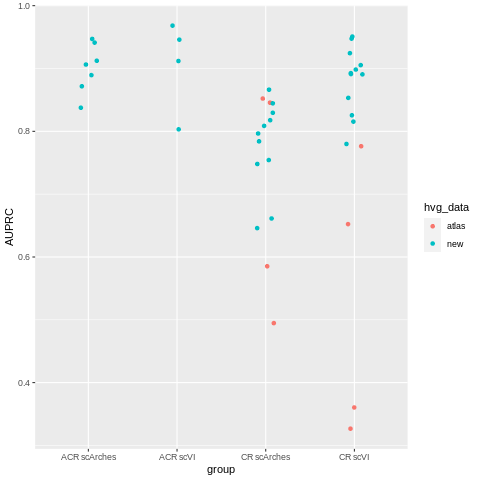

In [86]:
%%R
auprc_pl %>%
mutate(group = paste(design, emb_method)) %>%
ggplot(aes(group, AUPRC, color=hvg_data)) +
geom_jitter(width=0.1) 

In [134]:
adata = sc.read(simdir + '/ACR_design.scVI_milo.h5ad', backed=False)
adata_atlas = sc.read(simdir + '/ar_design.h5ad', backed=False)
adata_atlas = adata_atlas[adata_atlas.obs['dataset_group'] == 'atlas'].copy()

In [2]:
import scanpy as sc
adata = sc.read_h5ad(
    '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad')
adata_sim_obs = sc.read(simdir + '/model_atlasctrlquery/adata.h5ad', backed=True).obs
adata = adata[adata_sim_obs.index].copy()
adata.obs = pd.concat([adata.obs, adata_sim_obs[['dataset_group',	'OOR_state',	'cell_annotation','Site']]], 1)

/tmp/ipykernel_28758/2929683212.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([adata.obs, adata_sim_obs[['dataset_group',	'OOR_state',	'cell_annotation','Site']]], 1)


,sex,tissue,ethnicity,disease,assay,assay_ontology_term_id,sample_id,donor_id,dataset_id,development_stage,...,n_counts,_scvi_batch,_scvi_labels,leiden,cell_type_leiden,cell_type_leiden_frac,dataset_group,OOR_state,cell_annotation,Site
10_1126_science_abc6261-Arunachalam-cov07_TTGATGGAGCTGACTT-1,female,blood,European,normal,10x 3' v3,EFO:0009922,Arunachalam_cov07,cov07,10_1126_science_abc6261,84-year-old human stage,...,4666.0,1058,0,9,effector_memory_CD8_positive_alpha_beta_T_cell,0.569045,atlas,0,effector_memory_CD8_positive_alpha_beta_T_cell,cov
powell_eqtl-TCTATTGCATCATCCC-48,female,blood,European,normal,10x 3' v2,EFO:0009899,607_608,607_608,powell_eqtl,77-year-old human stage,...,4123.0,586,0,5,naive_thymus_derived_CD4_positive_alpha_beta_T...,0.642852,atlas,0,naive_thymus_derived_CD4_positive_alpha_beta_T...,607
powell_eqtl-CGTCACTCACACTGCG-48,female,blood,European,normal,10x 3' v2,EFO:0009899,607_608,607_608,powell_eqtl,77-year-old human stage,...,3906.0,586,0,4,memory_B_cell,0.391601,atlas,0,memory_B_cell,607
powell_eqtl-TACTCATAGATAGCAT-48,female,blood,European,normal,10x 3' v2,EFO:0009899,607_608,607_608,powell_eqtl,77-year-old human stage,...,1528.0,586,0,10,effector_memory_CD8_positive_alpha_beta_T_cell,0.603393,atlas,0,effector_memory_CD8_positive_alpha_beta_T_cell,607
powell_eqtl-TAGCCGGCACTGTCGG-48,female,blood,European,normal,10x 3' v2,EFO:0009899,607_608,607_608,powell_eqtl,77-year-old human stage,...,2034.0,586,0,11,effector_memory_CD8_positive_alpha_beta_T_cell,0.647397,atlas,0,effector_memory_CD8_positive_alpha_beta_T_cell,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_1038_s41591_021_01329_2-TGAAAGACATGGTAGG-MH8919278,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919278,MH8919278,10_1038_s41591_021_01329_2,third decade human stage,...,2687.0,1100,0,23,mucosal_invariant_T_cell,0.303259,query,0,mucosal_invariant_T_cell,MH8
10_1038_s41591_021_01329_2-TGCCCATCAAAGGTGC-MH8919278,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919278,MH8919278,10_1038_s41591_021_01329_2,third decade human stage,...,1951.0,1100,0,0,naive_B_cell,0.799189,query,0,naive_B_cell,MH8
10_1038_s41591_021_01329_2-AAACCTGAGTCTTGCA-MH8919278,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919278,MH8919278,10_1038_s41591_021_01329_2,third decade human stage,...,1716.0,1100,0,11,effector_memory_CD8_positive_alpha_beta_T_cell,0.647397,query,0,effector_memory_CD8_positive_alpha_beta_T_cell,MH8
10_1038_s41591_021_01329_2-CTGCTGTAGATATGCA-MH8919278,male,blood,unknown,normal,10x 3' transcription profiling,EFO:0030003,MH8919278,MH8919278,10_1038_s41591_021_01329_2,third decade human stage,...,1575.0,1100,0,0,naive_B_cell,0.799189,query,0,naive_B_cell,MH8


In [4]:
if 'X_scVI' in adata.obsm:
    del adata.obsm['X_scVI']

adata.obs['Site'] = adata.obs['donor_id'].str[0:3] ## Only for Stephenson data


array([ 1.,  2.,  1., ...,  1., 11.,  2.], dtype=float32)

```
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/_misc/hvg_selection/

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/
cts="natural_killer_cell classical_monocyte naive_B_cell central_memory_CD4_positive_alpha_beta_T_cell"
dirs=$(for c in $cts; do dirname $outdir/*500cells*${c}*/ACR_design.scArches_milo.h5ad; done)

for d in $dirs; do
    design=ACR
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --n_hvgs 2500" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --n_hvgs 10000" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    design=CR
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scVI --n_hvgs 2500" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --n_hvgs 2500" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scVI --n_hvgs 10000" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    echo "python compare_hvg_selection.py ${d}/ ${design} --embedding_method scArches --n_hvgs 10000" | \
                    bsub -G team283 -o logfile-hvgs-%J.out -e logfile-hvgs-%J.err -q gpu-normal -M50000 -R "select[mem>50000] rusage[mem=50000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1"
    done
```